### imports

In [405]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# exploration and preprocessing
1. Convert non-numeric features to numeric/dummy
2. Fill out missing values


In [406]:
data = pd.read_csv('train.csv')
data.set_index('id')

Y = data.loc[:,'purchase'] 
X = data.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.8,random_state=23)


print('first glance:')
X_train.head(5)


first glance:


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
2442,2442,0.0,0.000000,0.0,0.0 minutes,5.0,108.0 minutes,108.000000,0.000000,0.080000,...,May,2.0,chrome_90.1.7,3.0,Returning_Visitor,False,c_13,92.047040,log202,NaN
4138,4138,7.0,188.166667,0.0,0.0 minutes,52.0,1089.642857 minutes,1277.809524,0.003509,0.010234,...,May,2.0,browser_5_v19,6.0,Returning_Visitor,True,c_5,95.347227,log8080,NaN
8935,8935,7.0,133.466667,4.0,46.5 minutes,26.0,1357.833333 minutes,NaN,0.000000,0.018487,...,Nov,3.0,chrome_89,9.0,New_Visitor,True,c_2,87.950930,log202,NaN
3648,3648,4.0,259.000000,1.0,42.0 minutes,18.0,401.968254 minutes,NaN,0.000000,0.017105,...,May,1.0,safari_14,3.0,Returning_Visitor,False,c_3,109.345812,log404,NaN
10110,10110,1.0,153.500000,0.0,0.0 minutes,NaN,1002.847222 minutes,NaN,0.000000,0.009524,...,Nov,2.0,chrome_90.1.7,4.0,Returning_Visitor,False,c_2,117.950076,log200,NaN


In [407]:
print("** types: **")
print(X_train.dtypes)

print('\n** label values: **\n',y_train.value_counts())
print(f'purchased sessions are around {int((y_train.loc[y_train == 1].shape[0] / y_train.shape[0]) * 100)}% of all sessions')

** types: **
id                         int64
num_of_admin_pages       float64
admin_page_duration      float64
num_of_info_pages        float64
info_page_duration        object
num_of_product_pages     float64
product_page_duration     object
total_duration           float64
BounceRates              float64
ExitRates                float64
PageValues               float64
closeness_to_holiday     float64
Month                     object
device                   float64
internet_browser          object
Region                   float64
user_type                 object
Weekend                   object
A                         object
B                        float64
C                         object
D                        float64
dtype: object

** label values: **
 0    1768
1     327
Name: purchase, dtype: int64
purchased sessions are around 15% of all sessions


### page durations

In [408]:
## convert to numeric
fields = ['info_page_duration', 'product_page_duration']

for field in fields:
    print(field, 'str structure:', X_train[field].value_counts().index[0])
    

    # make sure all durations are in minutes
    print('not minutes count: ', len(X_train.loc[~X_train[field].str.contains('minutes').astype('bool'),(field)]))
    print('nan count: ', X_train[field].isnull().sum())


    # convert to float `type(d)==str ` handles nan values
    X_train[field] = [float(d.split()[0]) if type(d) is str else np.nan for d in X_train[field]]

print('new types:')
X_train.dtypes[fields]




info_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  58
product_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  136
new types:


info_page_duration       float64
product_page_duration    float64
dtype: object

In [409]:
## fill missing vlaues
avg_time_in_admin_page = (X_train.admin_page_duration / X_train.num_of_admin_pages).mean()
avg_time_in_info_page = (X_train.info_page_duration / X_train.num_of_info_pages).mean()
avg_time_in_product_page = (X_train.product_page_duration / X_train.num_of_product_pages).mean()

fields.append('admin_page_duration')
avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)

for i, field in enumerate(fields):
    X_train[field] = X_train[field].fillna(avgs[i])



In [410]:
## total duration
computed_durations = X_train.admin_page_duration + X_train.info_page_duration + X_train.product_page_duration

X_train.total_duration = X_train.total_duration.fillna(computed_durations)

### num of page visits

In [411]:
# fill missing values
fields = ('num_of_info_pages', 'num_of_product_pages' ,'num_of_admin_pages' )
avg_num_of_admin_pages = (X_train.admin_page_duration / avg_time_in_admin_page).mean()
avg_num_of_info_pages = (X_train.info_page_duration / avg_time_in_info_page).mean()
avg_num_of_product_pages = (X_train.product_page_duration / avg_time_in_product_page).mean()

avgs = (avg_num_of_info_pages, avg_num_of_product_pages, avg_num_of_admin_pages)

for i, field in enumerate(fields):
    X_train[field] = X_train[field].fillna(avgs[i])

### user type
user type has mainly two values, `New_Visitor` and  `Returning_Visitor`.
We wanted to see if we can map it to a binary feature.
For this, we:
1. made sure that `nan` and `other` are very rare
2. made sure there is no strong correlation between `other` and the label or featrue.

In [412]:
# check values
vc = X_train.user_type.value_counts()
nan_count = X_train.user_type.isnull().sum()
print('original user type values:\n', vc)
print('nan count        :', nan_count)
print('\n`other` categoryh is only ', f"{round(vc['Other'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('`Returning_Visitor` categoryh is ', f"{round(vc['Returning_Visitor'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('nan values are only ', f"{round(nan_count / X_train.shape[0] * 100, 2)}%", 'of the data')



original user type values:
 Returning_Visitor    1781
New_Visitor           290
Other                  17
Name: user_type, dtype: int64
nan count        : 7

`other` categoryh is only  0.81% of the data
`Returning_Visitor` categoryh is  85.01% of the data
nan values are only  0.33% of the data


explore correlations betwenn user type and other features

In [413]:
X_train_user_dummy = pd.get_dummies(X_train,columns=['user_type'],drop_first=False)

<AxesSubplot:>

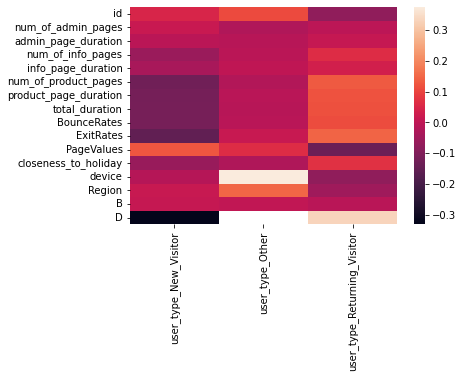

In [414]:
sb.heatmap(X_train_user_dummy.corr()[16:19].T[:16])

In [415]:
print('Device of "other" user_type')
print(X_train.loc[X_train.user_type == 'Other', ('device')].value_counts())
print('\nDevice of all user_types')
X_train.device.value_counts()

Device of "other" user_type
8.0    11
2.0     3
1.0     2
Name: device, dtype: int64

Device of all user_types


2.0    1063
3.0     432
1.0     424
4.0      84
8.0      14
6.0       2
7.0       1
Name: device, dtype: int64

### user_type - conclusion
two interesting correlartion here:  
a. `device` and `Other`:   
altough device 8 is very rare, almost all of device 8 sessions are `other`.  
It may mean that device 8 has some bug when collecing `user_type` data. However for our purpose it is not helpful (We were looking for a way to turn "other" to one of the other two.)  
b. `D`. but since `D` is mostly missing values, We shall treat `user type` as binary: only new users (0) and returing users (1)

In [416]:
#  map 'Returning_Visitor' , missing value and  'other' to 1, and New_Visitor to 0
RETURNING ='Returning_Visitor'

X_train.user_type = [1 if u_type == RETURNING else 0 for u_type in X_train.user_type] 




## D
d's seem to have mostly nan values
If it's lower than 10%, we will remove it altogether

In [417]:
valid_ds = X_train.loc[~np.isnan(X.D)]
print('only', str((valid_ds.shape[0] / X_train.shape[0]) * 100)[:3], "% of D's have values")

# remove D feature
X_train = X_train.drop(columns=('D'))
print("D feature removed")
del valid_ds


only 0.9 % of D's have values
D feature removed


## Bounce rate,  Exit rate, Page value

In [418]:
print('BounceRates nan count:', X_train.BounceRates.isnull().sum())
print('ExitRates nan count:', X_train.ExitRates.isnull().sum())
print('page values nan count:', X_train.PageValues.isnull().sum())

# so little nan values - lets fill with mean
X_train.BounceRates = X_train.BounceRates.fillna(X_train.BounceRates.mean())
X_train.ExitRates = X_train.ExitRates.fillna(X_train.ExitRates.mean())
X_train.PageValues = X_train.PageValues.fillna(X_train.PageValues.mean())


BounceRates nan count: 5
ExitRates nan count: 3
page values nan count: 6


closeness_to_holiday nan caount: 85


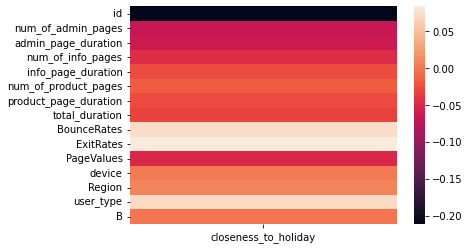

In [419]:
print('closeness_to_holiday nan caount:', X_train.closeness_to_holiday.isnull().sum())
corr = X_train.corr()
sb.heatmap(corr.iloc[11:12].T[corr.columns != 'closeness_to_holiday'])
pass


In [420]:
print("no intersting correlataions, using mean")
X_train.closeness_to_holiday = X_train.closeness_to_holiday.fillna(X_train.closeness_to_holiday.mean())


no intersting correlataions, using mean


## Device

In [421]:
X_train.device.value_counts()

device_mapper = {1.0: '1', 2.0: '2', 3.0: '3', 'Default': 'other'}
def make_dummy_device(data: pd.DataFrame):
    data.device = [device_mapper.get(d, device_mapper['Default']) for d in data.device]
    return pd.get_dummies(data=data, columns=['device'], drop_first=False)
    
X_train = make_dummy_device(X_train)

In [422]:
X_train.columns

Index(['id', 'num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',
       'info_page_duration', 'num_of_product_pages', 'product_page_duration',
       'total_duration', 'BounceRates', 'ExitRates', 'PageValues',
       'closeness_to_holiday', 'Month', 'internet_browser', 'Region',
       'user_type', 'Weekend', 'A', 'B', 'C', 'device_1', 'device_2',
       'device_3', 'device_other'],
      dtype='object')

## Histogram

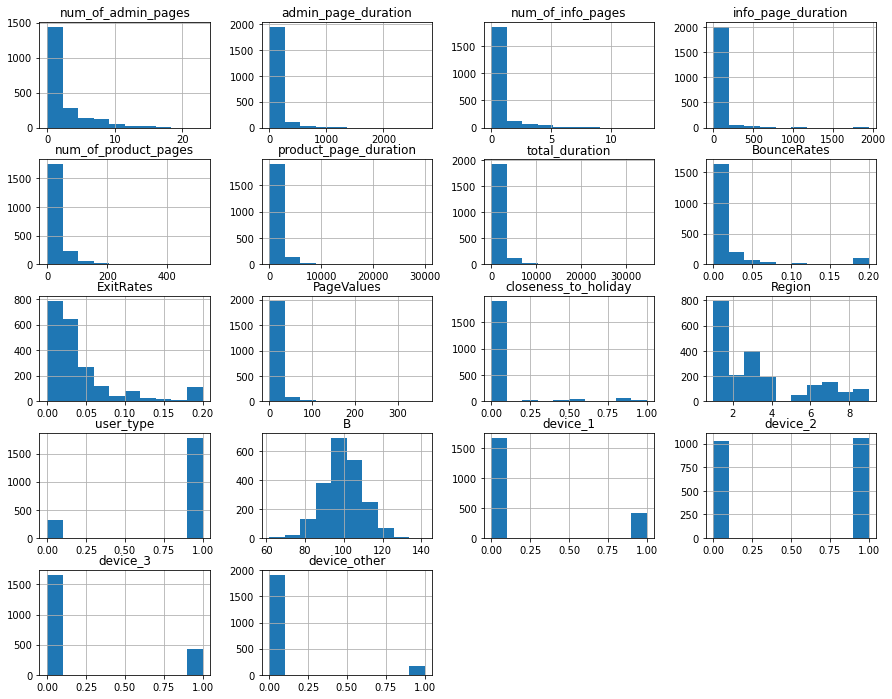

In [423]:
X_train.iloc[:,1:].hist(figsize=(15,12))
pass

<AxesSubplot:>

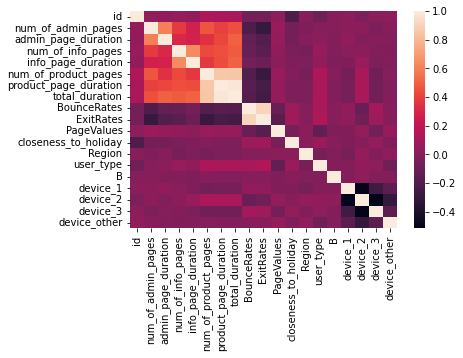

In [424]:
corr = X_train.corr()
sb.heatmap(corr)

In [425]:
X_train.C.value_counts()
X_train_no_C = X_train.copy()
X_train_no_C = X_train_no_C.drop(columns=('C'))
X_train = pd.get_dummies(X_train,columns=['C'],drop_first=True)


## weekand

In [426]:
# inital values
X_train.Weekend.value_counts
X_train.Weekend = [1 if w else 0 for w in X_train.Weekend]
X_train.Weekend.value_counts()


0    1588
1     507
Name: Weekend, dtype: int64

In [427]:
print("B nan count:", X_train.B.isnull().sum())
X_train.B = X_train.B.fillna(X_train.B.mean())
print("B nan count after filling:", X_train.B.isnull().sum())

X_train.head(3)



B nan count: 6
B nan count after filling: 0


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,B,device_1,device_2,device_3,device_other,C_log202,C_log400,C_log404,C_log8080,C_log_100
2442,2442,0.0,0.000000,0.0,0.0,5.0,108.000000,108.000000,0.000000,0.080000,...,92.047040,0,1,0,0,1,0,0,0,0
4138,4138,7.0,188.166667,0.0,0.0,52.0,1089.642857,1277.809524,0.003509,0.010234,...,95.347227,0,1,0,0,0,0,0,1,0
8935,8935,7.0,133.466667,4.0,46.5,26.0,1357.833333,1537.800000,0.000000,0.018487,...,87.950930,0,0,1,0,1,0,0,0,0


## browser

In [428]:
X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')
X_train['internet_browser'] = X_train['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

print(X_train.internet_browser.value_counts())

# corr = X_train.corr()
# sb.heatmap(corr.iloc[8:15].T[corr.columns != 'internet_browser'])


# X_train.internet_browser = ['Other' if i == 'nan' else X_train.internet_browser]


chrome     1286
safari      380
browser     192
nan         123
edge        114
Name: internet_browser, dtype: int64


C:\Users\itayz\AppData\Local\Temp\ipykernel_14952\2263388854.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')


In [429]:
X_train = pd.get_dummies(X_train,columns=['internet_browser'],drop_first=False)

<AxesSubplot:>

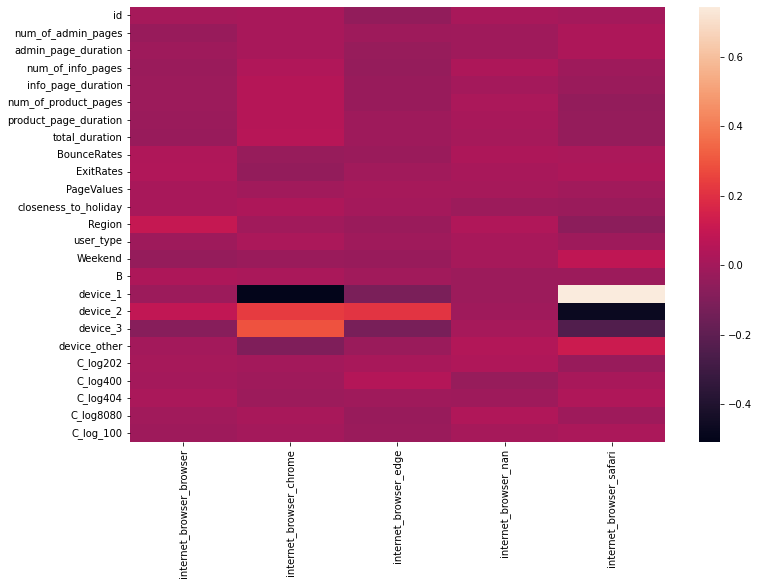

In [430]:
corr = X_train.corr()
plt.figure(figsize=(12,8))
sb.heatmap(corr.iloc[25:32].T[~corr.columns.str.startswith('internet_browser')])


In [431]:



# X_train[(X_train.internet_browser_chrome < 1)].internet_browser_chrome
# X_train[(X_train.internet_browser_chrome < 1)].iloc[:, -1][4138]

### fill na - browser
we can see there's a link between device and browswer, device 1 linked to safari (probelbly iphone/mac?) and devices 2 and 3 linked to chrome.

In [432]:
int_is_nan = X_train[X_train.internet_browser_nan == 1]


# device 1 means safari
X_train.loc[(X_train.internet_browser_nan == 1) & (X_train.device_1 > 0), ('internet_browser_safari',)] = 1

# device 2/3 means chrome
X_train.loc[(X_train.internet_browser_nan == 1) & (X_train.device_2 + X_train.device_3  > 0), ('internet_browser_chrome',)] = 1

    

In [433]:
print(X_train.loc[(X_train.internet_browser_nan == 1) & (X_train.device_other == 1)].shape[0], ' nan values left. we shall fill it with chrome - chrome is the most common')

# # fill with chrome
X_train.loc[(X_train.internet_browser_nan == 1) & (X_train.device_other == 1), 'internet_browser_chrome'] = 1

# make sure no nan left 
print(X_train.loc[(X_train.internet_browser_nan == 1) & ((X_train.internet_browser_chrome + X_train.internet_browser_safari) < 1)].shape[0], ' nan values left.')

16  nan values left. we shall fill it with chrome - chrome is the most common
0  nan values left.


## month
divide to 4 yearly quarters

In [434]:
Month = {'JAN':1, 'Feb':1, 'Mar':1, 'APR':2, 'May':2, 'June':2, 'Jul':3, 'Aug':3, 'Sep':3, 'Oct':4, 'Nov':4, 'Dec':4}
X_train.Month = X_train.Month.map(Month)
X_train.Month.value_counts()


4.0    895
2.0    621
1.0    338
3.0    235
Name: Month, dtype: int64

## Region

In [435]:
print(X_train.Region.value_counts())
print('nan count before:', X_train.Region.isnull().sum())

# fill nan with median
X_train.Region[X_train.Region.isnull()] = np.median(X_train.Region[~X_train.Region.isnull()])

print('nan count after:', X_train.Region.isnull().sum())



1.0    795
3.0    398
2.0    205
4.0    189
7.0    155
6.0    131
9.0     96
8.0     76
5.0     48
Name: Region, dtype: int64
nan count before: 2
nan count after: 0


C:\Users\itayz\AppData\Local\Temp\ipykernel_14952\2419433420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.Region[X_train.Region.isnull()] = np.median(X_train.Region[~X_train.Region.isnull()])


nan count 2
nan count 0


C:\Users\itayz\AppData\Local\Temp\ipykernel_14952\930415643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.Region[X_train.Region.isnull()] = 3.0
